In [172]:
import os
from google.colab import drive
drive.mount('/content/drive')

root_path = "/content/drive/My Drive/PNEUMONIA_data"

Mounted at /content/drive


In [0]:
training_path = os.path.join(root_path, "PNEUMONIA_train.npz")
validation_path = os.path.join(root_path, "PNEUMONIA_val.npz")
testing_path = os.path.join(root_path, "PNEUMONIA_test.npz")

In [174]:
from numpy import load
training_data = load(training_path)
X_train, y_train = training_data['arr_0'],training_data['arr_1']
print("Training data loaded")
validation_data = load(validation_path)
X_val, y_val = validation_data['arr_0'],validation_data['arr_1']
print("Validation data loaded")
testing_data = load(testing_path)
X_test, y_test = testing_data['arr_0'],testing_data['arr_1']
print("Testing data loaded")


Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7ff9fad73d30>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 225, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected


Training data loaded
Validation data loaded


Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7ffa4c3c8dd8>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 225, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected
Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7ffab8c41c88>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 225, in close
    self.fid.close()
OSError: [Errno 107] Transport endpoint is not connected


Testing data loaded


In [175]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(5216, 256, 256, 3) (5216,)
(16, 256, 256, 3) (16,)
(624, 256, 256, 3) (624,)


In [176]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
#tf.enable_eager_execution()
#AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 1.14.0


In [0]:
from keras.utils import np_utils, to_categorical

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense

from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras.applications.inception_v3 import InceptionV3

In [0]:
from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop

In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import tensorflow as tf

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib import pyplot

import matplotlib.image as mpimg

# Normalizing data 

In [0]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Viewing images

In [0]:
def show_plot(images):
    for i in range(len(images)):
        # define subplot
        pyplot.subplot(1, len(images), 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(images[i])
        # title
    pyplot.show()

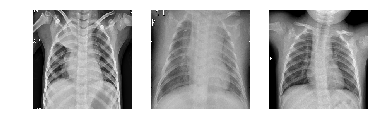

In [182]:
show_plot(X_train[:3])

# Training splitup

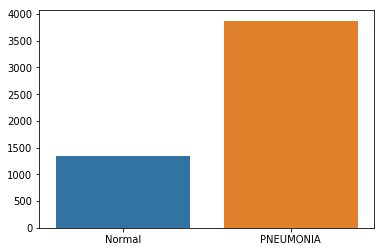

In [183]:
sns.barplot(x=["Normal","PNEUMONIA"], y=[len(y_train[y_train == 0]),len(y_train[y_train == 1])])

# Class weights

In [0]:
class_weight = {0: len(y_train[y_train == 1])/len(y_train),
                1: len(y_train[y_train == 0])/len(y_train)}

In [185]:
class_weight

{0: 0.7429064417177914, 1: 0.2570935582822086}

# Validation splitup

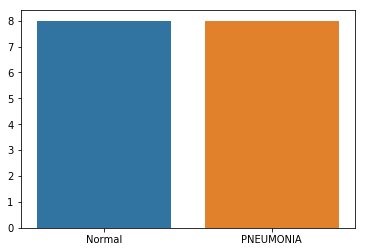

In [186]:
sns.barplot(x=["Normal","PNEUMONIA"], y=[len(y_val[y_val == 0]),len(y_val[y_val == 1])])

# Testing splitup

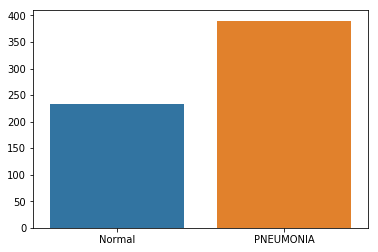

In [187]:
sns.barplot(x=["Normal","PNEUMONIA"], y=[len(y_test[y_test == 0]),len(y_test[y_test == 1])])

# Training model

In [0]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [0]:
model_file = "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

In [0]:
checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

In [0]:
callbacks = [checkpoint]

In [0]:
tf.compat.v1.disable_eager_execution()


In [0]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(256,256,3)))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2 , activation='softmax'))


    print(model.summary())
    
    return model


In [0]:
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(256,256,3))
  print("Base model loaded")
  x = base_model.output
  x = Dropout(0.35)(x)
  x = GlobalAveragePooling2D()(x)  
  x = Dense(512, activation='relu')(x)
  x = Dense(256, activation='relu')(x)
  x = BatchNormalization()(x)
  predictions = Dense(2, activation='softmax')(x)
  model = Model(inputs=base_model.input, outputs=predictions)
  #for layer in base_model.layers:
  #      layer.trainable = False
  print("Model definition complete")
  #print(model.summary())
  return model

In [199]:
model = get_model()

Base model loaded
Model definition complete


In [0]:
optimizer=optimizers.Adam(lr = 0.0005)
loss='binary_crossentropy'
metrics=['categorical_accuracy']
epochs = 20
batch_size =64

In [0]:
model.compile(optimizer, loss=loss, metrics=metrics)


In [202]:
model.fit(X_train,y_train,epochs = epochs, batch_size = batch_size, validation_data=(X_val, y_val), verbose = True, class_weight = class_weight)

Train on 5216 samples, validate on 16 samples
Epoch 1/20
5216/5216 [==============================] - 161s 31ms/step - loss: 0.0454 - categorical_accuracy: 0.9555 - val_loss: 0.1054 - val_categorical_accuracy: 0.9375
Epoch 2/20
5216/5216 [==============================] - 127s 24ms/step - loss: 0.0174 - categorical_accuracy: 0.9831 - val_loss: 0.0672 - val_categorical_accuracy: 1.0000
Epoch 3/20
5216/5216 [==============================] - 127s 24ms/step - loss: 0.0084 - categorical_accuracy: 0.9929 - val_loss: 0.1437 - val_categorical_accuracy: 0.8750
Epoch 4/20
5216/5216 [==============================] - 127s 24ms/step - loss: 0.0083 - categorical_accuracy: 0.9921 - val_loss: 0.3131 - val_categorical_accuracy: 0.9375
Epoch 5/20
5216/5216 [==============================] - 128s 25ms/step - loss: 0.0097 - categorical_accuracy: 0.9904 - val_loss: 0.0050 - val_categorical_accuracy: 1.0000
Epoch 6/20
5216/5216 [==============================] - 128s 25ms/step - loss: 0.0087 - categorical

# Save model

In [203]:
from keras.models import model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


# Load model

In [204]:
from keras.models import model_from_json
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")


optimizer=optimizers.Adam(lr = 0.0005)
loss='binary_crossentropy'
metrics=['categorical_accuracy']
loaded_model.compile(optimizer, loss=loss, metrics=metrics)


Loaded model from disk


# Testing model

In [205]:
score = model.evaluate(X_test, y_test, verbose=1)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

624/624 [==============================] - 22s 35ms/step
categorical_accuracy: 81.41%


In [206]:
y_predict = model.predict(X_test, verbose=1)

624/624 [==============================] - 15s 23ms/step


In [0]:
y_predict = y_predict.argmax(axis=-1)


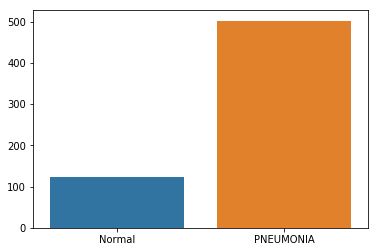

In [208]:
sns.barplot(x=["Normal","PNEUMONIA"], y=[len(y_predict[y_predict == 0]),len(y_predict[y_predict == 1])])

In [209]:
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=-1), y_predict, target_names=["Normal","PNEUMONIA"]))

              precision    recall  f1-score   support

      Normal       0.98      0.51      0.67       234
   PNEUMONIA       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.77       624
weighted avg       0.85      0.81      0.80       624



In [210]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test.argmax(axis=-1), y_predict))

[[120 114]
 [  2 388]]


In [0]:
import random

# Test 1

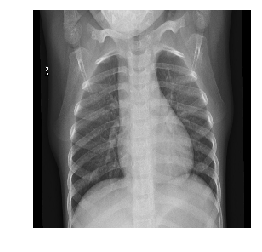

Actual:  0
Res:  0


In [224]:
rand_int = random.randrange(0,len(X_test))
show_plot([X_test[rand_int]])
print("Actual: ", y_test[rand_int].argmax(axis=-1))
print("Res: ", y_predict[rand_int].argmax(axis=-1))


# Test 2

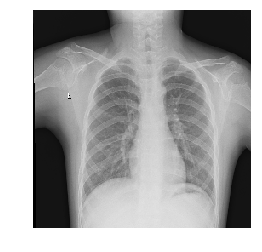

Actual:  0
Res:  0


In [226]:
rand_int = random.randrange(0,len(X_test))
show_plot([X_test[rand_int]])
print("Actual: ", y_test[rand_int].argmax(axis=-1))
print("Res: ", y_predict[rand_int].argmax(axis=-1))


# Test 3

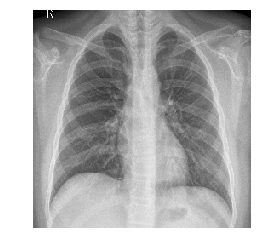

Actual:  0
Res:  0


In [249]:
rand_int = random.randrange(0,len(X_test))
show_plot([X_test[rand_int]])
print("Actual: ", y_test[rand_int].argmax(axis=-1))
print("Res: ", y_predict[rand_int].argmax(axis=-1
                                         ))
